In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 5)

In [3]:
df = pd.read_excel('proshares_analysis_data copy.xlsx',2, index_col=0)
df = df.sub(df['USGG3M Index'], axis=0)
del df['USGG3M Index']
df

,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,
2011-08-31,-0.05498,-0.09256,-0.08756,-0.00590,-0.08892
2011-09-30,-0.06947,-0.17908,-0.10810,0.14216,-0.11156
2011-10-31,0.10916,0.16300,0.09629,-0.06949,0.15102
2011-11-30,-0.00406,-0.01972,-0.02176,0.05463,-0.00378
2011-12-31,0.01043,-0.04303,-0.02215,0.07557,0.00511
...,...,...,...,...,...
2021-05-31,0.00656,0.01648,0.03482,-0.02717,0.00271
2021-06-30,0.02244,0.00943,-0.01085,0.05582,0.01867
2021-07-31,0.02438,-0.06440,0.00770,-0.00171,-0.03631


In [4]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [ ]:
#take the mean_vol_sharpe for specific dates like ['1926','1980']
def stats_by_date(df, start_date, end_date):
    df = mean_vol_sharpe(df.loc[start_date:end_date])
    df.rename(columns={'mean':'mean '+start_date+'-'+end_date}, inplace=True)
    df.rename(columns={'volatility':'volatility '+start_date+'-'+end_date}, inplace=True)
    df.rename(columns={'sharpe_ratio':'sharpe_ratio '+start_date+'-'+end_date}, inplace=True)
    return df

In [ ]:
def table_row(df, portfolio, annualize_factor=12):
    mean = df[portfolio].mean() * annualize_factor
    vol = df[portfolio].std() * np.sqrt(annualize_factor)
    sharpe_ratio = mean/vol
    skew = df[portfolio].skew() #unscaled
    corr = df[[portfolio, 'MKT', 'HML']].corr()
    corr_to_mkt = corr.loc[portfolio, 'MKT']
    corr_to_value = corr.loc[portfolio, 'HML']
    return [mean, vol, sharpe_ratio, skew, corr_to_mkt, corr_to_value]


table1 = pd.DataFrame(index=['1927-2021', '1927-1993', '1994-2008', '2009-2021'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table1.loc['1927-2021', :] = table_row(df_mom_size.loc['1927':'2020',:], portfolio='rx_mom_FF')
table1.loc['1927-1993', :] = table_row(df_mom_size.loc['1927':'1993',:], portfolio='rx_mom_FF')
table1.loc['1994-2008', :] = table_row(df_mom_size.loc['1994':'2008',:], portfolio='rx_mom_FF')
table1.loc['2009-2021', :] = table_row(df_mom_size.loc['2009':'2020',:], portfolio='rx_mom_FF')
table1.style.set_caption('Solution Table 1: Momentum performance over time.')

<AxesSubplot:>

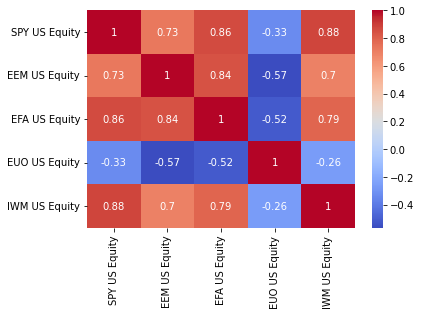

In [5]:
#Heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [6]:
#Correlation matrix ranking minimum and maximum
corr = df.corr()
corr[corr == 1] = np.nan
corr.unstack().sort_values(ascending=False)[:1]

SPY US Equity  IWM US Equity    0.88162
dtype: float64

In [7]:
# $ \omega_t for total return $
def tangency_portfolio(df, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    scaling = np.ones(N)@sig_inv@mu
    om_t = (1/scaling) * sig_inv @ mu
    
    return om_t

In [8]:
# $ \omega_min_variance for total return $
def min_variance_portfolio(df, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    
    scaling = np.ones(N) @ sig_inv @ np.ones(N)
    omega_v = (1/scaling) * sig_inv @ np.ones(N)
    
    return omega_v

In [ ]:
#Calculate OMEGA* for total return

n = 11
np.ones(n)
sigma = df.cov() * 12
sigma_i=np.linalg.inv(sigma)
mean_ret = df.mean() * 12
scaling = 1/ (np.ones(n)@sigma_i@mean_ret)
omega_t = pd.DataFrame (scaling * sigma_i  @ mean_ret, index = df.columns, columns = ['Weights'])
#omega_t.T
mu_p = 0.015 * 12
scaling = 1/ (np.ones(n)@sigma_i@np.ones(n).T)
omega_v = pd.DataFrame (scaling * sigma_i  @ np.ones(n).T, index = df.columns, columns = ['Weights'])
delta = (mu_p - mean_ret.T @ omega_v)/(mean_ret.T @ omega_t - mean_ret.T @ omega_v)

omega = omega_v + delta*(omega_t - omega_v)
omega.T

In [ ]:
def delta(df, ann=12, u_p=0.015):
    
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    mu_p = u_p * ann
    scaling = 1/ (np.ones(N)@sig_inv@np.ones(N).T)
    mean_ret = df.mean() * ann
    delta = (mu_p - mean_ret.T @ min_variance_portfolio(df))/(mean_ret.T @ tangency_portfolio(df) - mean_ret.T @ min_variance_portfolio(df))

    omega = min_variance_portfolio(df) + delta*(tangency_portfolio(df) - min_variance_portfolio(df))
    omega.T
    
    return print(delta, omega)

In [ ]:
def portfolio_stats(df, weights, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    
    mu_p = weights.T @ mu
    sig_p = np.sqrt(weights.T @ sig @ weights)
    sharpe_p = mu_p/sig_p
    
    print('Mean: ', mu_p, ',\nVol: ', sig_p, ',\nSharpe Ratio: ', sharpe_p)

In [ ]:
#equally weighted portfolio

weights_equal = weights_equal * (mean_target*12 / (ret_mean @ weights_equal))
weights_equal
###
#Equally weighted portfolio
eq_weights = np.ones(11)/11
eq_weights
eq_resc = eq_weights * mu_p / (mean_ret @ eq_weights)
port_stats(data,eq_resc)

In [ ]:
# weight parity

weight_parity = 1/ret_vol
weight_parity = weight_parity * (mean_target*12 / (ret_mean @ weight_parity))
####
w = 1 / (data.std())

scaling = 1 / ((w @ mean_ret) / mu_p)

w = scaling * w
w

In [ ]:
## TANGENCY for Portfolio with excess returns

def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    # For convenience, I'll wrap the solution back into a pandas.Series object.
    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    
    return omega_tangency, mu_tilde, Sigma_adj

In [ ]:
### TARGET MV Portfolio for excess returns

def target_mv_portfolio(df_tilde, target_return=0.01, diagonalize_Sigma=False):

    omega_tangency, mu_tilde, Sigma = compute_tangency(df_tilde, diagonalize_Sigma=diagonalize_Sigma)

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    Sigma_inv = np.linalg.inv(Sigma_adj)

    N = Sigma_adj.shape[0]

    delta_tilde = ((np.ones(N) @ Sigma_inv @ mu_tilde)/(mu_tilde @ Sigma_inv @ mu_tilde)) * target_return

    omega_star = delta_tilde * omega_tangency

    return omega_star, mu_tilde, Sigma_adj

omega_star,_,_ = target_mv_portfolio(df, 0.02)
omega_star.to_frame('MV Portfolio Weights').T

In [ ]:
# Since the total weights added up is above 1, the portfolio is short in risk-free rate
omega_star.sum()

1.157561083377907

In [ ]:
df_mf_ex_is = df.loc[:'2018-12-31',]
df_mf_ex_oos = df.loc['2019-01-01':,]

omega_star_is,_,_ = target_mv_portfolio(df_mf_ex_is, 0.02)
omega_star_is

In [ ]:
mean_vol_sharpe(pd.DataFrame(df_mf_ex_oos @ omega_star_is),12)

## HW 2

In [ ]:
def risk_stats(data, q=0.05):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR (negated)'] = -df.quantile(q)
    report.loc['Expected Shortfall (negated)'] = -df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None
    report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days
    return round(report,4)
risk_stats(df, 0.05)

In [ ]:
#Regression with OLS and intercept
regression_report = pd.DataFrame(index=portfolios_excess_1981.columns)
x = sm.add_constant(factor_mkt)

for i in portfolios_excess_1981.columns:
    y = portfolios_excess_1981[i]
    model = sm.OLS(y,x,missing='drop').fit()
    regression_report.loc[i,'alpha'] = model.params['const'] * 12
    regression_report.loc[i,'beta'] = model.params['Mkt-RF']
    regression_report.loc[i,'treynor ratio'] = portfolios_excess_1981[i].mean() * 12 / model.params[1]
    regression_report.loc[i,'info ratio'] = model.params[0] * np.sqrt(12) / model.resid.std()



In [ ]:
#OLS with intercept
y = df['SPY US Equity']
X = sm.add_constant(df)
reg = sm.OLS(y, X).fit()
print("Residuals std dev annuallized: ", reg.resid.std() * np.sqrt(12))
reg.summary()

In [22]:
#Regression without intercept

y = df['EEM US Equity']
#del df['SPY US Equity']
x = df['SPY US Equity']

reg = sm.OLS(y,x).fit()
reg.params

SPY US Equity    0.92566
dtype: float64

In [20]:
df_hedge = df.copy()
df_hedge['hedge'] = df['EEM US Equity'] - df['SPY US Equity'] * reg.params[0]
mean_vol_sharpe(df_hedge, 12)[-1:]

,mean,volatility,sharpe_ratio
hedge,-0.09351,0.12581,-0.74326


In [ ]:
#Rolling OLS

model_60 = RollingOLS(y, X, window=60)
model_60_beta = model_60.fit().params.copy()
model_60.fit().params.tail(5)

In [ ]:
is_replication = (model_60_beta * X).sum(axis=1, skipna=False)
out_replication = (model_60_beta.shift(1) * X).sum(axis=1, skipna=False)

rep_df = pd.DataFrame({'in_sample': is_replication, 'out_sample': out_replication, 'HFRIFWI Index': y, 'static':reg.fittedvalues})
rep_df.corr()

In [32]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [47]:
dfn = pd.read_excel('proshares_analysis_data copy.xlsx',2, index_col=0)
dfn_log = np.log(1+dfn)
dfn_log.head(3)

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,
2011-08-31,-0.05654,8.49996e-06,-0.09712,-0.09162,-0.00591,-0.09312
2011-09-30,-0.07198,1.69165e-05,-0.19731,-0.11438,0.13294,-0.11827
2011-10-31,0.10359,-1.26667e-05,0.15099,0.09192,-0.07204,0.14064


In [48]:
dfn['diff'] = dfn['SPY US Equity'] - dfn['EFA US Equity']
mu_tilde = dfn['diff'].mean()*12
sig_tilde = dfn['diff'].std()*np.sqrt(12)

1-prob([10], mu_tilde, sig_tilde)

,Probability
h,
10,0.99962


In [50]:

sigma_rolling = dfn_log['EFA US Equity'].dropna().rolling(60).std()
latest_sigma = sigma_rolling[-1]
var_estimate = -2.33 * latest_sigma
var_estimate

-0.09783869148216545

## TIMESERIES TEST

In [2]:
def ts_test(df, factor_df, factors, constant = True,annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha','f_1','f_2', 'r_2', 'treynor', 'info'])
    
    for port in df.columns:
        y = df[port]
        if constant:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        
        if constant:
            beta = model.params[1:]
            alpha = model.params[0] * annualization
            information_ratio = model.params[0] * np.sqrt(annualization) / model.resid.std()
        else:
            beta = model.params
    
        treynor = df[port].mean() * annualization / beta[0]
        tracking_error = model.resid.std() * np.sqrt(annualization)
        if constant:
            res.loc[port] = [alpha, model.params[1], model.params[2], model.rsquared, treynor, information_ratio]
        else:
            res.loc[port] = [None, model.params[0], model.params[1], model.rsquared, treynor, None]
    return res

#df is the asset portfolios which we are regressing
#factor_df is the factor data
#intercept is whether we want to include an intercept in the regression

### FACTOR PREMIA IS JUST THE MEAN OF THE FACTOR(S)

In [4]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

# mean_vol_sharpe(df).iloc[:,0]

### MAE

In [6]:
#round(df_ts['alpha'].abs().mean(),5)

## Timeseries PREMIUM FROM THE MODEL

In [7]:
#factor_mean = mean_vol_sharpe(df).iloc[:,0]
#df_ts astype float

#df_ts is the asset portfolios which we are regressing
#factor_df is the factor data
def ts_premia(df_ts, factor_mean):
    #multiply factor premium row wise to each f_1 an f_2 in factor and sum
    premia = pd.DataFrame(data = None, index = df_ts.index, columns = ['TS Premia'])
    for row in df_ts.index:
        a = df_ts.loc[row, 'f_1']* factor_mean[0]
        b = df_ts.loc[row, 'f_2']* factor_mean[1]
        premia.loc[row] = a + b
        
    return premia

# Cross sectional regression dont use

In [ ]:
# def ts_betas(df, factor_df, factors, intercept=False):
#     if intercept == True:
#         res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha'])
#         res[factors] = None
#     else:
#         res = pd.DataFrame(data = None, index = df.columns, columns = factors)
    
#     for port in df.columns:
#         y = df[port]
#         if intercept == True:
#             X = sm.add_constant(factor_df[factors])
#         else:
#             X = factor_df[factors]
#         model = sm.OLS(y, X).fit()
#         res.loc[port] = model.params

#     return res

# def cross_section(df, factor_df, factors, ts_int=True, annualization=12):
#     betas = ts_betas(df, factor_df, factors, intercept=ts_int)
#     res = pd.DataFrame(data = None, index = betas.index, columns = factors)
#     res['Predicted'] = None
#     res['Actual'] = None
    
#     for port in res.index:
#         res.loc[port, factors] = betas.loc[port]
#         prem = (betas.loc[port] * factor_df[factors]).sum(axis=1).mean() * annualization
#         res.loc[port,['Predicted','Actual']] = prem, df[port].mean() * annualization
    
#     return res

# def cross_premia(df_cs, factors):
#     y = df_cs['Actual'].astype(float)
#     X = df_cs[factors].astype(float)

#     return sm.OLS(y,X).fit().params.to_frame('CS Premia')

# def cross_premia_mae(df_cs, factors, model):
#     y = df_cs['Actual'].astype(float)
#     X = df_cs[factors].astype(float)

#     return str(round(sm.OLS(y,X).fit().resid.abs().mean(), 4))

## Cross Sectional Regression for Means

In [2]:
def cross_regression(asset_df, factors_df, factors, intercept=True, annualization=12):
    
    res = pd.DataFrame(data = None, index = factors, columns = ['cs_premia'])
    
    factors_df = factors_df.iloc[:,1:(len(factors)+1)]
    
    y = asset_df.mean() * annualization
    if intercept == True:
        X = sm.add_constant(factors_df[factors].astype(float))
    else:
        X = factors_df[factors].astype(float)
    model = sm.OLS(y, X).fit()
    if intercept:
        alpha = model.params[0]
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i+1]
        predicted_premia = pd.DataFrame(model.resid.abs(), columns=['predicted_premia'])
    else:
        alpha = None
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i]
        predicted_premia = pd.DataFrame(model.resid.abs(), columns=['predicted_premia'])
    
    if intercept:
        return predicted_premia,res, f'r-squared = {round(model.rsquared, 4)}', f'alpha = {round(alpha, 4)}', f'mae = {round(mae, 4)}'
    else:
        return predicted_premia,res, f'r-squared = {round(model.rsquared, 4)}', f'mae = {round(mae, 4)}'

In [ ]:
aqr1 = ['f_1','f_2','f_3','f_4']
#predicted_premia,cs_premia,r2,mae = cross_regression(portfolios,aqr_test,aqr1,intercept=False)
#predicted_premia,cs_premia,r2,alpha,mae = cross_regression(portfolios,aqr_test,aqr1,intercept=True)
